<a href="https://colab.research.google.com/gist/CrissEliatrop/0d4d581fc88013c3699cd48aa8e1032c/kopia-notatnika-dynamic-programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# note this runtime does not require a GPU, so make sure the runtime type is set to CPU to lower your Colab usage

In [ ]:
# imports
import gym
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from gym.envs.toy_text.frozen_lake import generate_random_map

In [ ]:
# import the frozen lake gym environment
name = 'FrozenLake-v0'
 
random_map = generate_random_map(size=8, p=0.8)
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) # warning: setting slippery=True results in very complex environment dynamics where the optimal solution does not make sense to humans!

env.seed(742)
env.action_space.seed(742)

# lets examine it
print('action space: ' + str(env.action_space))
print('reward range: ' + str(env.reward_range))
print('observation space: ' + str(env.observation_space))
env.render()

action space: Discrete(4)
reward range: (0, 1)
observation space: Discrete(64)

SFFFFHHF
FHFFFFFF
FFHFFFHH
FHFFHFFF
HFFFHFFF
FFHFHFFF
FHHFFFFH
FHFFFFFG


In [ ]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# lets do an example step for the policy
env.reset()
next_state, reward, terminated, info = env.step(DOWN)
print('=============')
print('next state: ' + str(next_state))
print('terminated: ' + str(terminated))
print('    reward: ' + str(reward))
print('      info: ' + str(info))

next state: 8
terminated: False
    reward: 0.0
      info: {'prob': 1.0}


In [ ]:
# helper function to draw the frozen lake
def plot(V,policy,col_ramp=1,dpi=175,draw_vals=False):
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams.update({'axes.edgecolor': (0.32,0.36,0.38)})
    plt.rcParams.update({'font.size': 4 if env.env.nrow >= 6 else 7})
    plt.figure(figsize=(3,3))
    plt.imshow(1-V.reshape(env.env.nrow,env.env.ncol)**col_ramp, cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(env.env.ncol)-.5)
    ax.set_yticks(np.arange(env.env.nrow)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for s in range(env.nS):
        x = s%env.env.nrow
        y = int(s/env.env.ncol)
        a = policy[s]
        gray = np.array((0.32,0.36,0.38))
        if env.desc.tolist()[y][x] == b'G': 
            plt.text(x-0.45,y-0.3, 'goal', color=(0.75,0.22,0.17), fontname='OpenSans', weight='bold')
            continue
        if a[0] > 0.0: plt.arrow(x, y, float(a[0])*-.84, 0.0, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # left
        if a[1] > 0.0: plt.arrow(x, y, 0.0, float(a[1])*.84,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # down
        if a[2] > 0.0: plt.arrow(x, y, float(a[2])*.84, 0.0,  color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # right
        if a[3] > 0.0: plt.arrow(x, y, 0.0, float(a[3])*-.84, color=gray+0.2*(1-V[s]), head_width=0.1, head_length=0.1) # up
        if env.desc.tolist()[y][x] == b'F': plt.text(x-0.45,y-0.3, 'ice', color=(gray*V[s]), fontname='OpenSans')
        if env.desc.tolist()[y][x] == b'S': plt.text(x-0.45,y-0.3, 'start',color=(0.21,0.51,0.48), fontname='OpenSans', weight='bold')
        if draw_vals and V[s]>0:
            vstr = '{0:.1e}'.format(V[s]) if env.env.nrow == 8 else '{0:.6f}'.format(V[s])
            plt.text(x-0.45,y+0.45, vstr, color=(gray*V[s]), fontname='OpenSans')
    plt.grid(color=(0.42,0.46,0.48), linestyle=':')
    ax.set_axisbelow(True)
    ax.tick_params(color=(0.42,0.46,0.48),which='both',top='off',left='off',right='off',bottom='off')
    plt.show()

**Policy evaluation**

In [ ]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8, draw=False):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if draw: plot(V,policy,draw_vals=True)
        if delta < theta:
            break
    return V

In [ ]:
# lets start with a random policy, in this case there's a 1/4 probability of taking any action at every 4x4 state
policy = np.ones([env.nS, env.nA]) / env.nA

In [ ]:
# evaluate this policy (change draw=True to show steps, and ensure environment is 'FrozenLake-v0' for the exact same steps in the lecture)
V = policy_evaluation(env,policy,draw=False)

Get $q_\pi$ form $v_\pi$ by a one-step look ahead


In [ ]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

In [ ]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        
        # deterministic policy, will always choose an action (not capture the distribution)
        # policy[s][np.argmax(q)] = 1
        
        # stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

findfont: Font family ['OpenSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['OpenSans'] not found. Falling back to DejaVu Sans.


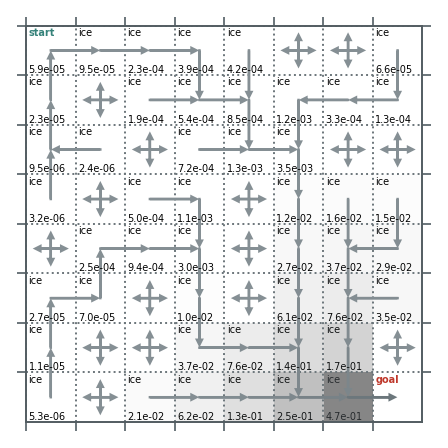

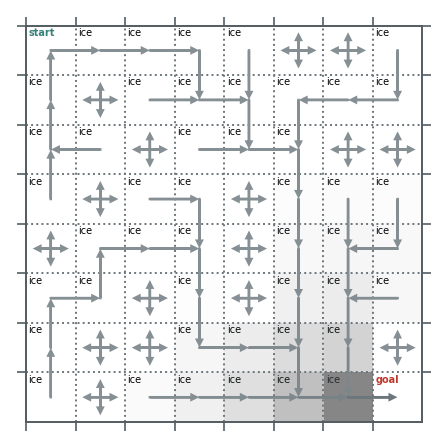

In [ ]:
# plot the policy from a single greedy improvement step after policy evaluation
policy = policy_improvement(env, V, gamma = 0.1)
plot(V,policy,1.0,draw_vals=True)
plot(V,policy,1.0,draw_vals=False)

In [ ]:
# now lets do value iteration, which is the k=1 case but simplifies saving computation
# note how there are no intermediate policies until the end 
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS) # initial state value function
    while True:
        delta = 0
        for s in range(env.nS):
            v_s = V[s] # store old value
            q_s = q_from_v(env, V, s, gamma) # the action value function is calculated for all actions
            V[s] = max(q_s) # the next value of the state function is the maximum of all action values
            delta = max(delta, abs(V[s] - v_s))
        if delta < theta: break
    # lastly, at convergence, we can get a (optimal) policy from the optimal state value function
    policy = policy_improvement(env, V, gamma)    
    return policy, V

In [ ]:
# now solve the MDP by policy iteration
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:

        # evaluate the policy (get the value function)
        V = policy_evaluation(env, policy, gamma, theta)

        # greedily choose the best action
        new_policy = policy_improvement(env, V)

        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
           break;
        
        policy = copy.copy(new_policy)
    return policy, V

In [ ]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=1)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)


KeyboardInterrupt: ignored

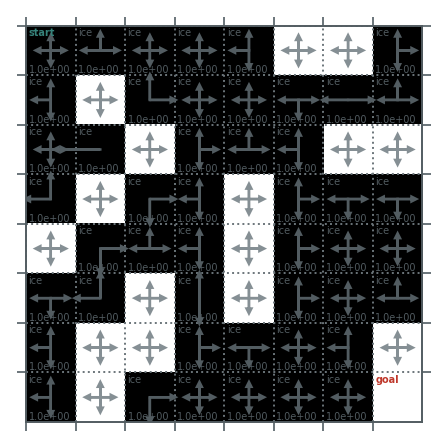

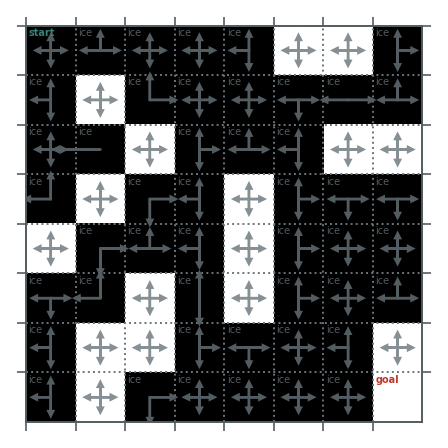

In [ ]:
policy_pi, V_pi = value_iteration(env, gamma=1)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)

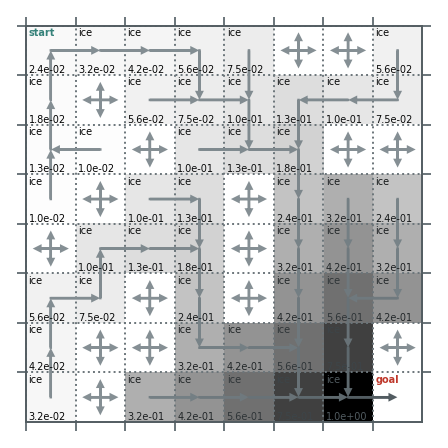

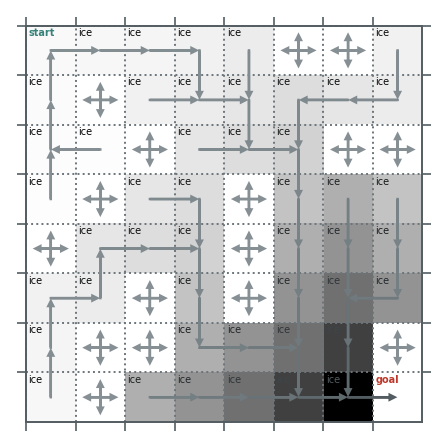

In [ ]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=0.75)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)


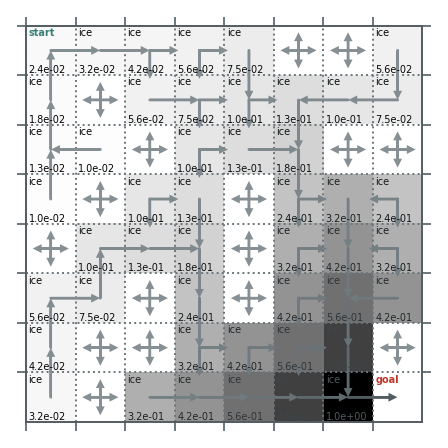

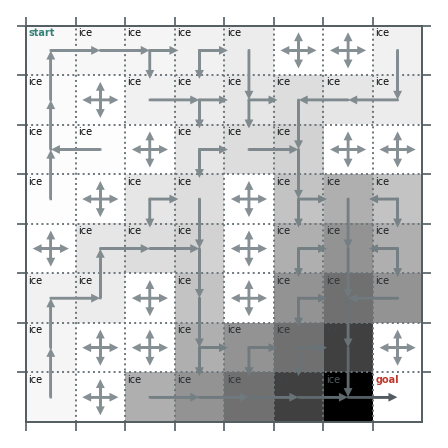

In [ ]:
policy_pi, V_pi = value_iteration(env, gamma=0.75)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)

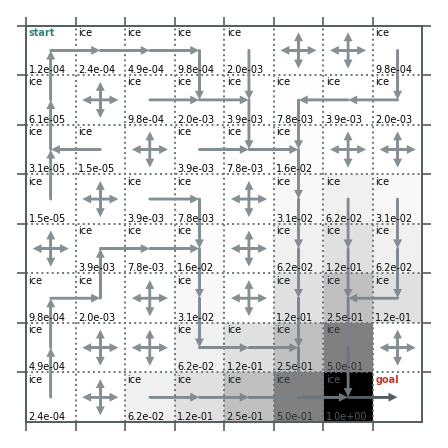

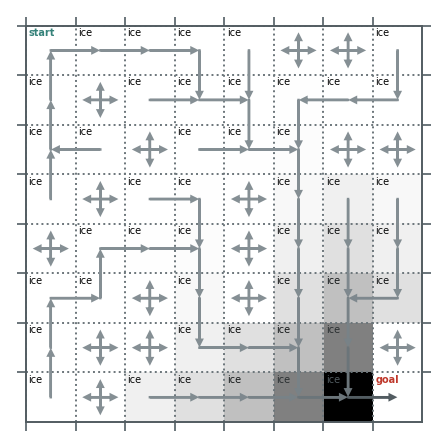

In [ ]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=0.5)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)


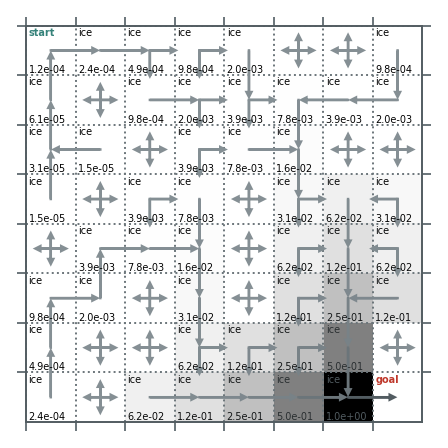

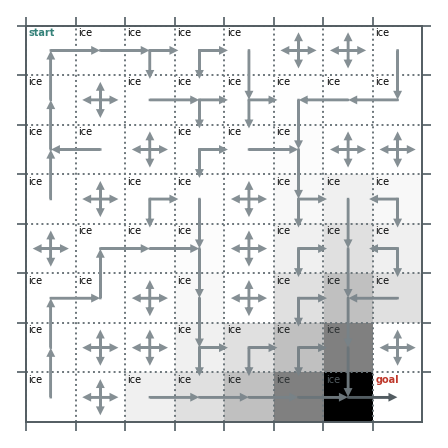

In [ ]:
policy_pi, V_pi = value_iteration(env, gamma=0.5)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)

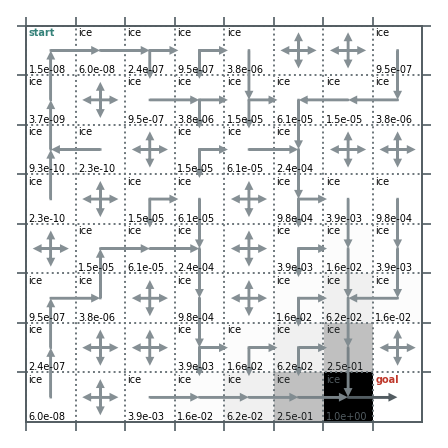

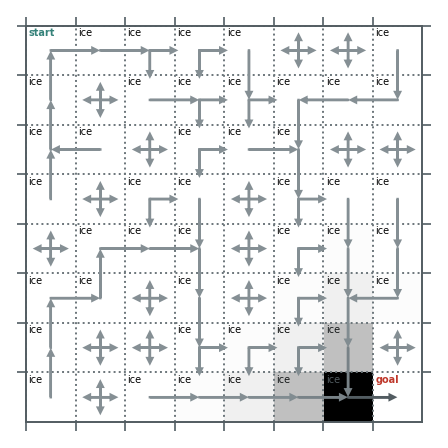

In [ ]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=0.25)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)


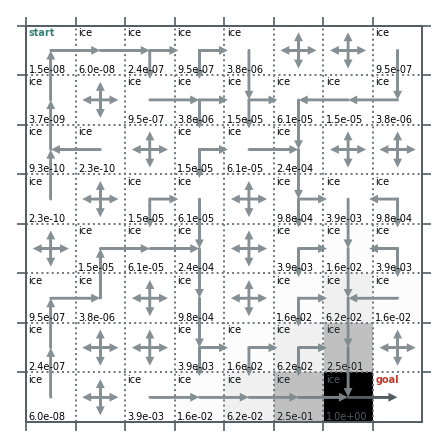

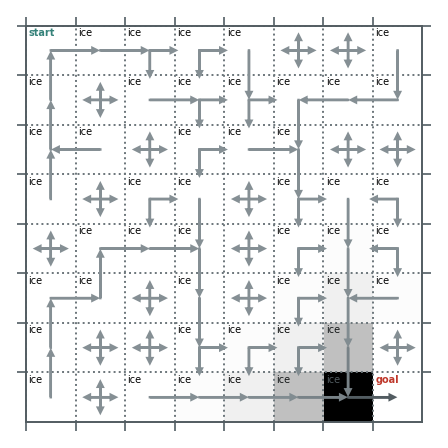

In [ ]:
policy_pi, V_pi = value_iteration(env, gamma=0.25)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)

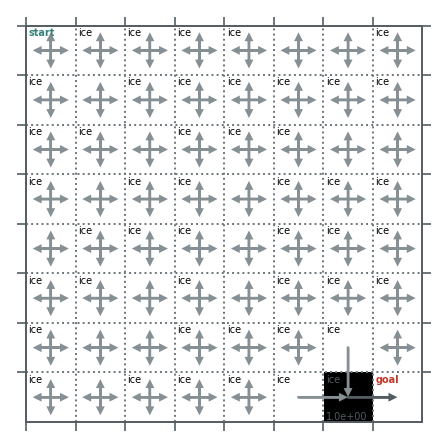

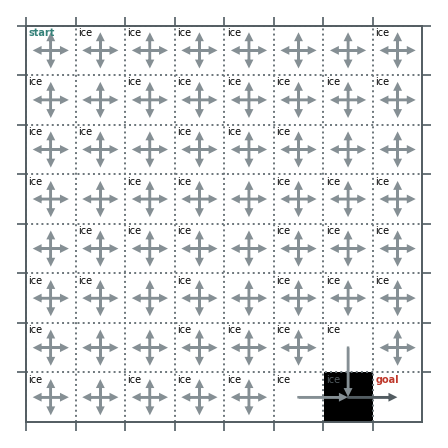

In [ ]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=0)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)


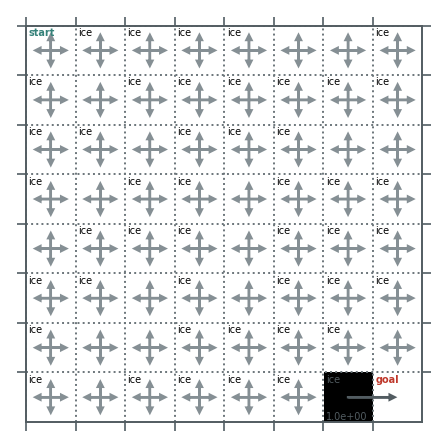

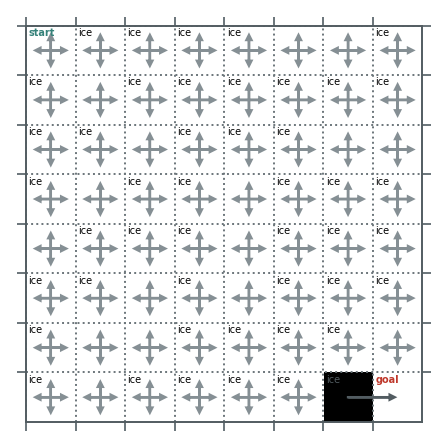

In [ ]:
policy_pi, V_pi = value_iteration(env, gamma=0)
plot(V_pi,policy_pi,1.0,draw_vals=True)
plot(V_pi,policy_pi,1.0,draw_vals=False)

1.	Jaki wpływ na jakość znalezienia drogi do frisbee ma wartość gamma?

Czym większa wartość gamma tym mniejsza nagroda i tym mniejsza ilość iteracji.


2.	Czym różnią się metody policy_iteration oraz value_iteration?

Policy iteration zajmuje się ocenę polityki i jej poprawą obie te czynności są powtarzane aż do znalezienia zbieżności przez co próbując różne wartości i porównując je dochodzi do najlepszej, natomiast value iteration nie ma powtórzeń powyższych czynności ponieważ gdy funkcja wartości jest optymalna to polityka wynikająca z niej też jest optymalna.


3.	Dlaczego value_iteration znajduje lepszą drogę niż policy_iteration

Z moich obserwacji wynika iż value_itteration i policy_itteration nie znajduje lepszej drogi metody znajdują podobną i optymalną drogę natomiast value jest w stanie poprowadzić nas do celu nie tylko jedną optymalną ścieżką a kilkoma.


